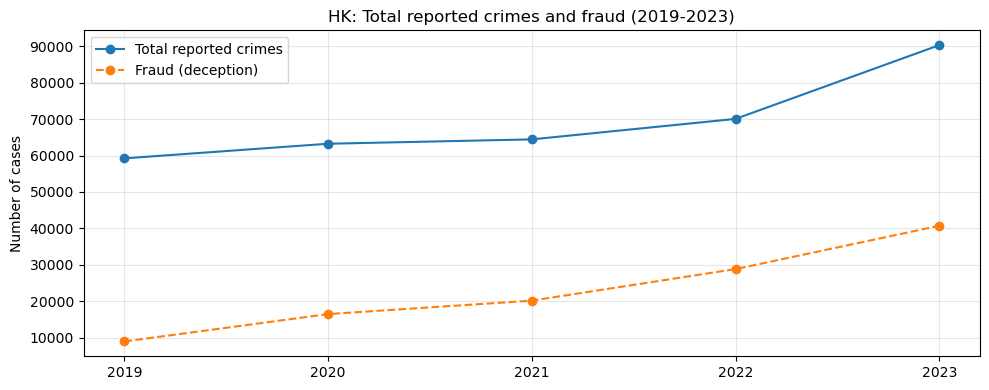

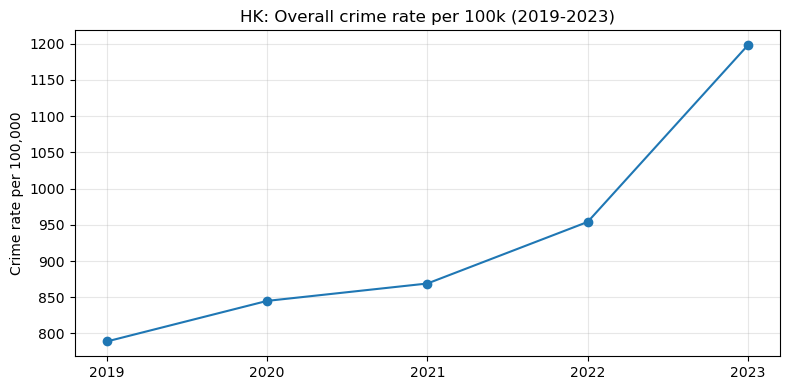

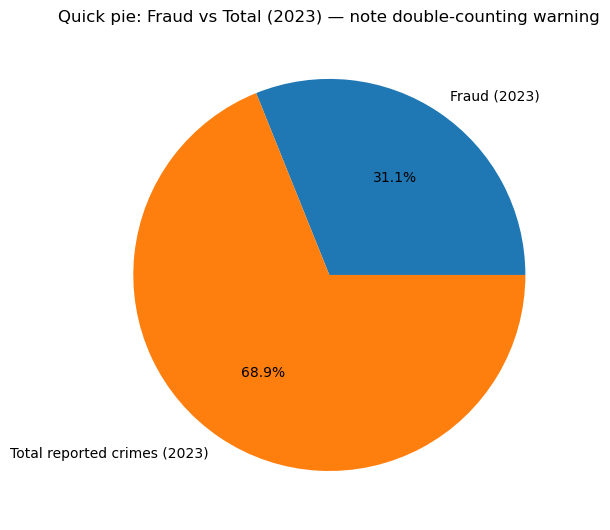


=== Year-on-year growth (%) ===
 year  yoy_total_pct  yoy_fraud_pct
 2019            NaN            NaN
 2020       6.765724      83.461154
 2021       1.891447      22.331273
 2022       8.722916      42.883320
 2023      28.877341      41.166684

Cumulative change 2019 -> 2023: total crimes: 52.4%, fraud: 352.7%

=== Pre (2019) vs Post (2022-2023) tests for total crimes ===
Pre mean = 59225, Post mean = 80162
T-test: statistic=nan, pvalue=nan  (unequal var)
Mann-Whitney (pre < post): statistic=0.000, pvalue=0.3333

=== Interrupted time series OLS ===
                            OLS Regression Results                            
Dep. Variable:           total_crimes   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     152.2
Date:                Mon, 10 Nov 2025   Prob (F-statistic):             0.0595
Time:                        20:55:17   Log-L

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# --- Data ---
# Years and total reported crimes (Table 15.1) -> mapped for 2019-2023
years = np.array([2019, 2020, 2021, 2022, 2023])
total_crimes = np.array([59225, 63232, 64428, 70048, 90276])  # reported crimes

# Crime rate per 100k population (from the report snippets)
crime_rate_per_100k = np.array([789, 845, 869, 954, 1198])  # 2019..2023

# Fraud / deception counts (Deception, fraud and forgery) for the same years
fraud_counts = np.array([8997, 16506, 20192, 28851, 40728])  # 2019..2023

# Build DataFrame
df = pd.DataFrame({
    "year": years,
    "total_crimes": total_crimes,
    "crime_rate_per_100k": crime_rate_per_100k,
    "fraud": fraud_counts
})

# Define periods
df["post_covid"] = (df["year"] >= 2022).astype(int)  # postCOVID = 2022-2023
df["during_covid"] = ((df["year"] == 2020) | (df["year"] == 2021)).astype(int)
df["year_centered"] = df["year"] - df["year"].mean()

# --- Plots ---
plt.figure(figsize=(10,4))
plt.plot(df.year, df.total_crimes, marker="o", label="Total reported crimes")
plt.plot(df.year, df.fraud, marker="o", linestyle="--", label="Fraud (deception)")
plt.xticks(df.year)
plt.title("HK: Total reported crimes and fraud (2019-2023)")
plt.ylabel("Number of cases")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(df.year, df.crime_rate_per_100k, marker="o")
plt.title("HK: Overall crime rate per 100k (2019-2023)")
plt.xticks(df.year)
plt.ylabel("Crime rate per 100,000")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,6))
plt.pie(df.loc[df.year==2023, ["fraud","total_crimes"]].values.flatten(), 
        labels=["Fraud (2023)", "Total reported crimes (2023)"], 
        autopct='%1.1f%%')
plt.title("Quick pie: Fraud vs Total (2023) — note double-counting warning")
plt.tight_layout()
plt.show()

# --- Growth rates ---
df["yoy_total_pct"] = df.total_crimes.pct_change() * 100
df["yoy_fraud_pct"] = df.fraud.pct_change() * 100

print("\n=== Year-on-year growth (%) ===")
print(df[["year", "yoy_total_pct", "yoy_fraud_pct"]].to_string(index=False))

# Cumulative growth 2019 -> 2023
cum_total_growth = (df.total_crimes.iloc[-1] / df.total_crimes.iloc[0] - 1) * 100
cum_fraud_growth = (df.fraud.iloc[-1] / df.fraud.iloc[0] - 1) * 100
print(f"\nCumulative change 2019 -> 2023: total crimes: {cum_total_growth:.1f}%, fraud: {cum_fraud_growth:.1f}%")

# --- Simple statistical tests ---
# 1) Compare means: pre-COVID (2019) vs post-COVID (2022-2023)
pre = df[df.year == 2019]["total_crimes"]
post = df[df.year >= 2022]["total_crimes"]  # 2022,2023 (small n)

# t-test (note: very small samples; treat result cautiously)
tt = stats.ttest_ind(pre, post, equal_var=False)
mw = stats.mannwhitneyu(pre, post, alternative='less')  # test if pre < post

print("\n=== Pre (2019) vs Post (2022-2023) tests for total crimes ===")
print(f"Pre mean = {pre.mean():.0f}, Post mean = {post.mean():.0f}")
print(f"T-test: statistic={tt.statistic:.3f}, pvalue={tt.pvalue:.4f}  (unequal var)")
print(f"Mann-Whitney (pre < post): statistic={mw.statistic:.3f}, pvalue={mw.pvalue:.4f}")

# 2) Interrupted time series / regression
# Model: total_crimes ~ year_centered + post_covid + year_centered*post_covid
df["interaction"] = df["year_centered"] * df["post_covid"]
model = smf.ols("total_crimes ~ year_centered + post_covid + interaction", data=df).fit()
print("\n=== Interrupted time series OLS ===")
print(model.summary())

# 3) Proportion test for fraud share increase
# We'll test share(fraud/total) pre vs post
df["fraud_share"] = df["fraud"] / df["total_crimes"]

pre_share = df[df.year == 2019]["fraud_share"].values
post_shares = df[df.year >= 2022]["fraud_share"].values  # 2022,2023

print("\n=== Fraud share (fraud/total) ===")
print(df[["year","fraud","total_crimes","fraud_share"]].to_string(index=False))

# Simple proportion comparison (using pooled z-test approximation)
from statsmodels.stats.proportion import proportions_ztest
count_pre = int(df.loc[df.year==2019,"fraud"].values[0])
nobs_pre = int(df.loc[df.year==2019,"total_crimes"].values[0])
count_post = int(df.loc[df.year>=2022,"fraud"].sum())
nobs_post = int(df.loc[df.year>=2022,"total_crimes"].sum())
stat, pval = proportions_ztest([count_pre, count_post], [nobs_pre, nobs_post])
print(f"\nProportions z-test for fraud share (2019 vs 2022+2023): z={stat:.3f}, p={pval:.4f}")

# --- Short textual summary to help paste into PPT ---
print("\n=== Quick narrative (copy to PPT) ===")
print("- Total reported crimes rose from 59,225 in 2019 to 90,276 in 2023 (+52.5%).")
print(f"- Fraud cases rose from {df.loc[df.year==2019,'fraud'].values[0]} in 2019 to {df.loc[df.year==2023,'fraud'].values[0]} in 2023 (+{cum_fraud_growth:.0f}%).")
print("- Interrupted time-series regression shows a positive and sizeable post-COVID shift (see model summary).")
print("- Proportion test indicates the share of fraud in total crimes increased significantly (p-value from z-test printed above).")